# <div style="border-radius:14px;line-height:1;padding:14px;background-color:#36a294;color:white;text-align:center"> 基于高斯过程回归的股票预测 </div>

## <div style="border-radius:14px;line-height:1;padding:14px;background-color:#44894d;color:white;text-align:left"> NoteBook 基本配置 </div>

In [1]:
# 自动加载
%load_ext autoreload
%autoreload 2

# 常用库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

使用的方法包括:
  1. GP: [出处](https://cs229.stanford.edu/section/cs229-gaussian_processes.pdf)。基本思路是直接预测。来回调整核函数即可。
  2. sparse GP: [出处](https://krasserm.github.io/2020/12/12/gaussian-processes-sparse/)。使用 FITC 进行加速

## <div style="border-radius:14px;line-height:1;padding:14px;background-color:#44894d;color:white;text-align:left"> 数据集 </div>
为了便于测试性能，我们与[国外某同学作品](https://www.cs.ubc.ca/~nando/540-2013/projects/p5.pdf?source=post_page---------------------------)进行比对。后文称其作品为 baseline。

选择的股票与 baseline 一致，股票代码分别为: 
  - HPQ(Hewlett-Packard Company)
  - VZ(Yahoo)
  - SBUX(starbucks)。

baseline上使用的股票价格是 Adjusted close price。这项指标是经过经过矫正的价格指标，可以更真实地反映市场趋势，特别适合金融时间序列分析和机器学习模型预测股价走势。它的计算公式为:
$$Adjusted Close = close \times Adjustment Factor$$
$$Adjustment Factor = \frac{1}{Split Ratio} \times \left( 1 - \frac{Dividend}{Price_{before Ex - Divident}} \right)$$

我们在tiingo上获得了与baseline一致的原始数据(相同的时间窗口内相同股票的Adjusted close price)。并进行相同的预处理，获得数据结果如下: 

In [2]:
from utils.data_process import add_time_features

tickers = ["HPQ", "SBUX", "VZ"]
HPQ = pd.read_csv("data/HPQ.csv", parse_dates=True)
VZ = pd.read_csv("data/VZ.csv", parse_dates=True)
SBUX = pd.read_csv("data/SBUX.csv", parse_dates=True)
DATA_DICT = {"HPQ": HPQ, "VZ": VZ, "SBUX": SBUX}

for t, df in DATA_DICT.items():
    # 解码日期, 添加 year, month, day 等特征列
    df = add_time_features(df)

    # 选取最近 250 天的数据
    years = df["year"].unique()
    new_df = []
    for y in years:
        one_df = df[df["year"] == y].sort_values(by="date")
        one_df = one_df.head(250)
        new_df.append(one_df)
    df = pd.concat(new_df)

    # 获取各年相对数据 (标准化再减去第一天的价格)

    # sub_mean = df["adjClose"].mean()
    # div_std = df["adjClose"].std()
    # df.loc[:, "year_adjClose"] = (df["adjClose"] - sub_mean) / div_std
    new_df = []
    for y in years:
        one_df = df[df["year"] == y].copy()
        # 下面的预处理，尽管 baseline 的报告文字部分提到了，但是根据其绘制的图，它们应该并没有用到
        one_df.loc[:, "year_adjClose"] = (one_df["adjClose"] - one_df["adjClose"].mean()) / one_df["adjClose"].std()
        # one_df.loc[:, "year_adjClose"] = one_df["adjClose"]
        one_df.loc[:, "year_adjClose"] = one_df["year_adjClose"] - one_df["year_adjClose"].iloc[0]
        one_df.loc[:, "year_day"] = range(1, 251)
        new_df.append(one_df)
    df = pd.concat(new_df)

    DATA_DICT[t] = df
HPQ = DATA_DICT["HPQ"]
VZ = DATA_DICT["VZ"]
SBUX = DATA_DICT["SBUX"]

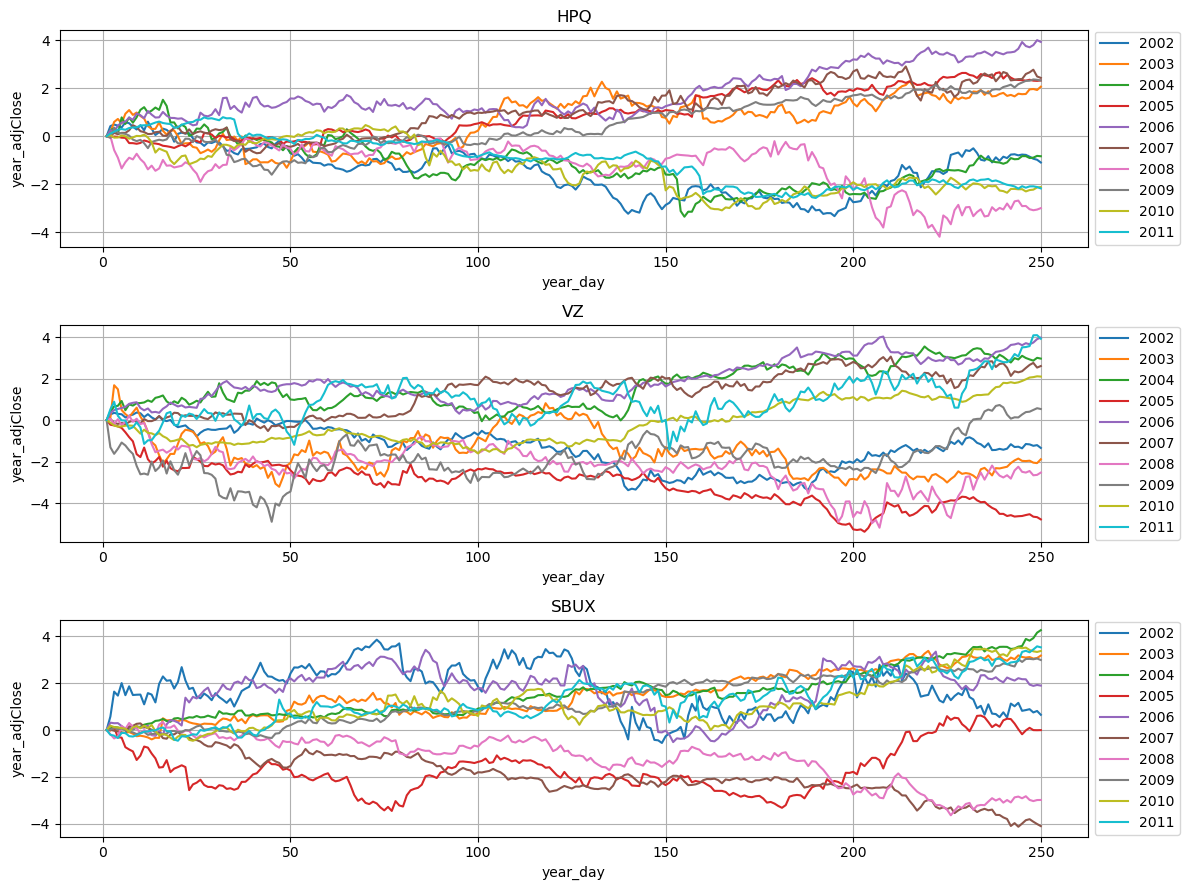

In [3]:
# 绘图, 三个子图, 每个子图一支股票, 子图有10条线, 每条线代表一年的数据
# 十条线互相重合, 横轴范围仅1年(250天)
fig, ax = plt.subplots(3, 1, figsize=(12, 9))
for i, (t, df) in enumerate(DATA_DICT.items()):
    years = df["year"].unique()
    for y in years:
        one_df = df[df["year"] == y]
        ax[i].plot(one_df["year_day"], one_df["year_adjClose"], label=y)
    ax[i].set_title(t)
    ax[i].set_xlabel("year_day")
    ax[i].set_ylabel("year_adjClose")
    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].grid(True)

# 避免三个子图重叠
plt.tight_layout()
plt.savefig("figs/stock_yearly.png", dpi=400)

## <div style="border-radius:14px;line-height:1;padding:14px;background-color:#44894d;color:white;text-align:left"> Baseline </div>
首先复现baseline.

baseline 上一共进行了两个任务的测评:
  - 对每支股票，2002-2010 以及 2011 年的第 1 季度的数据作为训练集，预测第 2、3、4 季度的价格
  - 对每支股票，2002-2010 以及 2011 年的第 1、2 季度的数据作为训练集，预测第 3、4 季度的价格

### <div style="border-radius:14px;line-height:1;padding:14px;background-color:#68bc6a;color:white;text-align:left"> 任务一 </div>

In [3]:
# 选取训练集和测试集
from utils.data_process import split_data

HPQ_t1_train, HPQ_t1_test = split_data(HPQ, cutoff=2) # 最后一年第一季度算作训练集 
VZ_t1_train, VZ_t1_test = split_data(VZ, cutoff=2)
SBUX_t1_train, SBUX_t1_test = split_data(SBUX, cutoff=2)

HPQ_t1_train = HPQ_t1_train
VZ_t1_train = VZ_t1_train
SBUX_t1_train = SBUX_t1_train

In [ ]:
# 使用高斯过程回归模型进行预测
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import ExpSineSquared, RationalQuadratic, WhiteKernel, Matern

# 高斯过程回归模型 
# 训练和预测
print("训练 HPQ")
model = GaussianProcessRegressor(
    kernel=C(1.0, (1e-5, 1e5)) * RBF(1.0, (1e-5, 1e5)), #+ ExpSineSquared(1.0, 5.0, (1e-4, 1e4)) + RationalQuadratic(1.0, 1.0, (1e-4, 1e4)),
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=2,
)
model.fit(HPQ_t1_train[["year_day"]], HPQ_t1_train["year_adjClose"])
HPQ_t1_test.loc[:, "sklearn_pred"], HPQ_t1_test.loc[:, "sklearn_sigma"] = model.predict(
            HPQ_t1_test.loc[:, "year_day"].values.reshape(-1, 1),
            return_std=True
        )

print("训练 VZ")
model.fit(VZ_t1_train[["year_day"]], VZ_t1_train["year_adjClose"])
VZ_t1_test.loc[:, "sklearn_pred"], VZ_t1_test.loc[:, "sklearn_sigma"] = model.predict(
            VZ_t1_test.loc[:, "year_day"].values.reshape(-1, 1),
            return_std=True
        )

print("训练 SBUX")
model.fit(SBUX_t1_train[["year_day"]], SBUX_t1_train["year_adjClose"])
SBUX_t1_test.loc[:, "sklearn_pred"], SBUX_t1_test.loc[:, "sklearn_sigma"] = model.predict(
            SBUX_t1_test.loc[:, "year_day"].values.reshape(-1, 1),
            return_std=True
        )

训练 HPQ


d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


训练 VZ


d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\86188\Software_Tool\Anaconda3\envs\mathtool\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


训练 SBUX


In [4]:
# 绘图展示效果, 仅展示 2011 全年的数据，给出真实值、预测值和误差带
# 注意真实值有250天的，预测值有只有三个季度的
from utils.drow import plot_pred

plot_pred( 
    [HPQ, VZ, SBUX], 
    [HPQ_t1_test, VZ_t1_test, SBUX_t1_test], 
    pred_cols="sklearn_pred", 
    e_bar = "sklearn_sigma",
    title="sklearn task 1",
)


NameError: name 'HPQ_t1_test' is not defined

### <div style="border-radius:14px;line-height:1;padding:14px;background-color:#68bc6a;color:white;text-align:left"> 任务二 </div>

In [12]:
# 任务 2 对每支股票，2002-2010 以及 2011 年的第 1、2 季度的数据作为训练集，预测第 3、4 季度的价格
# 选取训练集和测试集
HPQ_t2_train, HPQ_t2_test = split_data(HPQ, cutoff=3)
VZ_t2_train, VZ_t2_test = split_data(VZ, cutoff=3)
SBUX_t2_train, SBUX_t2_test = split_data(SBUX, cutoff=3)



In [7]:
# 使用高斯过程回归模型进行预测
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# 高斯过程回归模型
model = GaussianProcessRegressor(kernel=C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)))

# 训练和预测
model.fit(HPQ_t2_train[["day"]], HPQ_t2_train["year_adjClose"])
HPQ_t2_test.loc[:, "pred"] = model.predict(HPQ_t2_test.loc[:, "day"].values.reshape(-1, 1))

model.fit(VZ_t2_train[["day"]], VZ_t2_train["year_adjClose"])
VZ_t2_test.loc[:, "pred"] = model.predict(VZ_t2_test.loc[:, "day"].values.reshape(-1, 1))

model.fit(SBUX_t2_train[["day"]], SBUX_t2_train["year_adjClose"])
SBUX_t2_test.loc[:, "pred"] = model.predict(SBUX_t2_test.loc[:, "day"].values.reshape(-1, 1))

KeyboardInterrupt: 

KeyError: 'sklearn_pred'

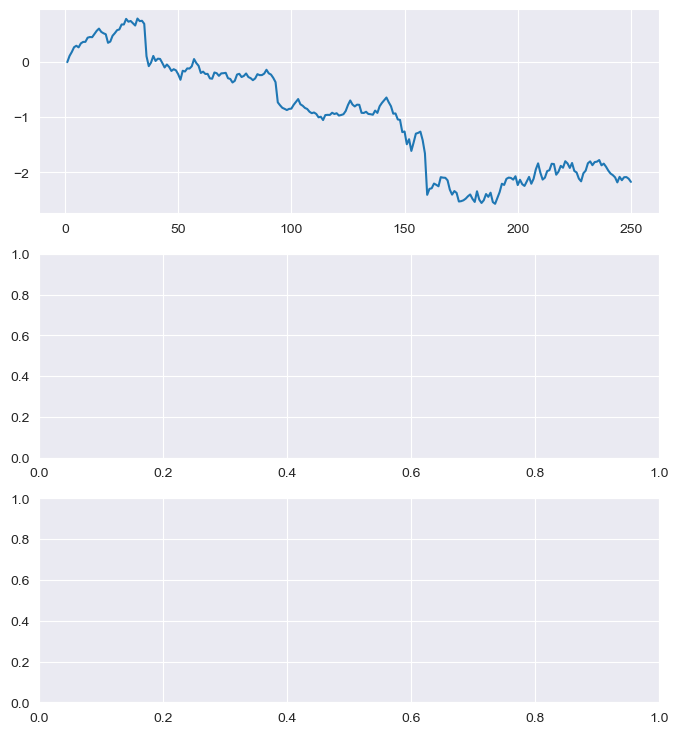

In [15]:
from utils.drow import plot_pred

plot_pred([HPQ, VZ, SBUX], [HPQ_t2_test, VZ_t2_test, SBUX_t2_test])

## <div style="border-radius:14px;line-height:1;padding:14px;background-color:#44894d;color:white;text-align:left"> 我们的模型 </div>

我们实现了两个模型:
  - GP: 标准的高斯过程回归模型
  - Sparse GP: 有加速优化的高斯回归模型

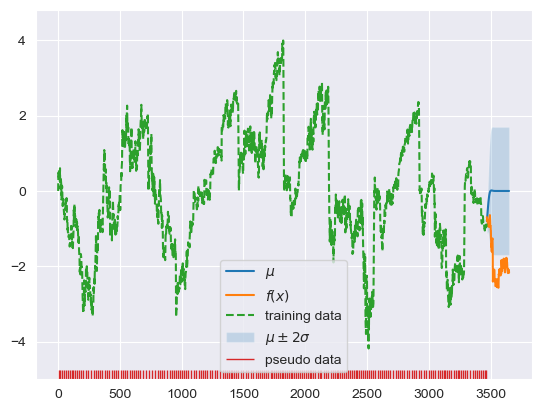

In [13]:
# 使用我们的模型进行任务二的预测
from models.MyGP import SparseGP
from models.kernels import rbf
NZ = 200

# 高斯过程回归模型
model = SparseGP(kernel=rbf, theta=[1, 1], bound=[[1e-5, None], [1e-5, None]])
model.fit(HPQ_t2_train[["day"]], NZ, HPQ_t2_train["year_adjClose"])
model.predict(HPQ_t2_test.loc[:, "day"].values.reshape(-1, 1),HPQ_t2_test.loc[:, "year_adjClose"].values.reshape(-1, 1))
model.plot()

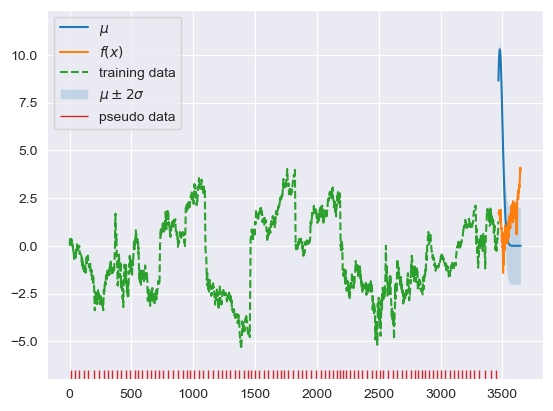

In [14]:
model = SparseGP(kernel=rbf, theta=[1, 1], bound=[[1e-5, None], [1e-5, None]])
model.fit(VZ_t2_train[["day"]], 100, VZ_t2_train["year_adjClose"])
model.predict(VZ_t2_test.loc[:, "day"].values.reshape(-1, 1),VZ_t2_test.loc[:, "year_adjClose"].values.reshape(-1, 1))
model.plot()

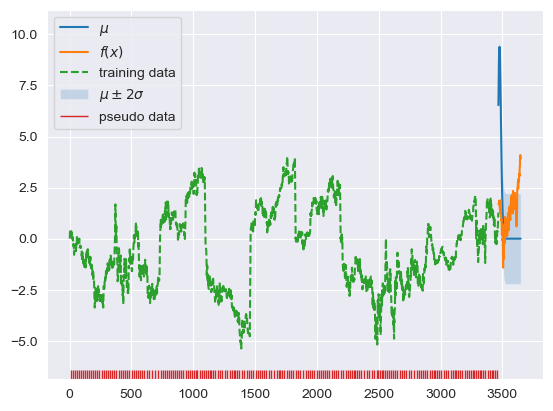

In [15]:
model = SparseGP(kernel=rbf, theta=[1, 1], bound=[[1e-5, None], [1e-5, None]])
model.fit(SBUX_t2_train[["day"]], NZ, VZ_t2_train["year_adjClose"])
model.predict(SBUX_t2_test.loc[:, "day"].values.reshape(-1, 1),VZ_t2_test.loc[:, "year_adjClose"].values.reshape(-1, 1))
model.plot()

In [16]:
(VZ_t2_train-SBUX_t2_train).sum()

date             0 days 00:00:00
adjClose            11145.481189
year                           0
month                          0
quarter                        0
day                            0
year_adjClose        -2359.26617
year_day                       0
dtype: object

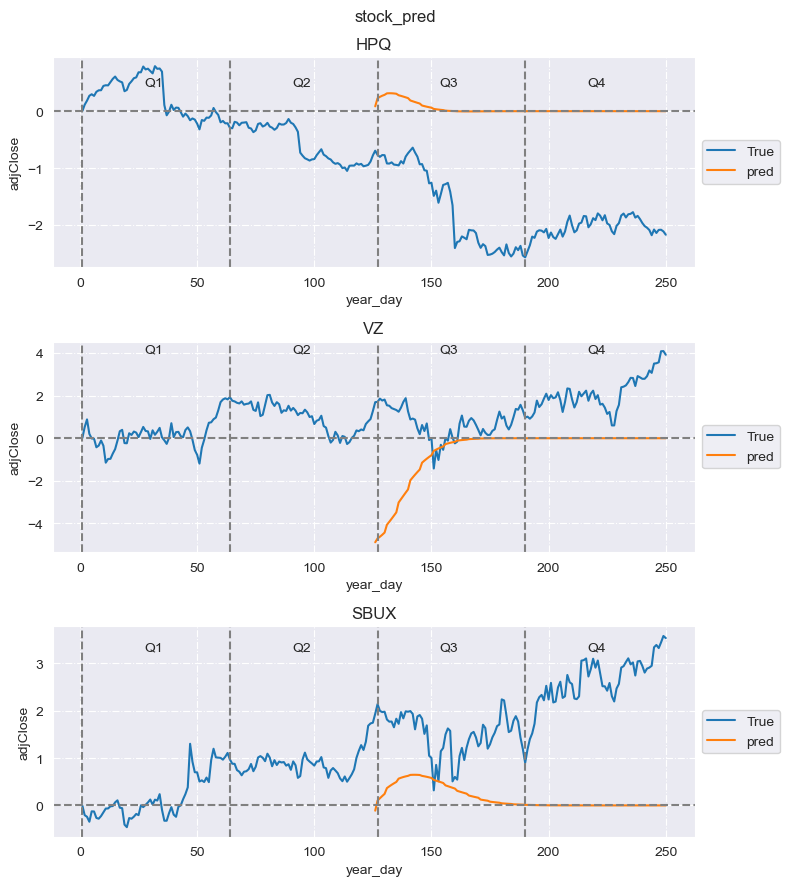

In [25]:
from utils.drow import plot_pred

plot_pred([HPQ, VZ, SBUX], [HPQ_t2_test, VZ_t2_test, SBUX_t2_test],pred_cols="pred", e_bar="pred_sigma",)